# PIV

[![Google Collab Book](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tum-pbs/PhiFlow/blob/develop/examples/optim/PIV.ipynb)

This example performs simulates the movement of particles in a fluid and then performs particle image velocimitry (PIV) to reconstruct the fluid field.

In [ ]:
%pip install --quiet phiflow
from phi.jax.flow import *
# from phi.flow import *  # If JAX is not installed. You can use phi.torch or phi.tf as well.
from tqdm.notebook import trange

We begin by constructing a divergence-free velocity field and scattering marker particles across the domain.
Doing this for various numbers of markers (128 to 4096) will allow us to examine the scaling behavior later.

<Figure size 360x216 with 2 Axes>

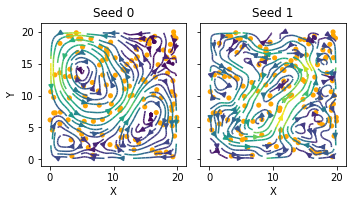

In [46]:
v0 = StaggeredGrid(Noise(batch(seed=2)), x=64, y=64, bounds=Box(x=20, y=20))
v0, _ = fluid.make_incompressible(v0)
marker_count = vec(batch('count'), 128, 256, 512, 1024, 2048, 4096)
initial_markers = v0.bounds.sample_uniform(instance(markers=marker_count))
plot([Sphere(initial_markers.count['128'], radius=.4), v0], overlay='list', color=['orange', None], size=(5, 3))

Next, we get the marker positions after a small time $\Delta t = 0.1s$.

In [9]:
@jit_compile
def simulate(v):  # v is the guess for the velocity
    return advect.points(initial_markers, v, dt=.1, integrator=advect.rk4)

final_markers = simulate(v0)

From the marker positionos, we now reconstruct the velocity field.
We first do a rough fit at quarter resolution before performing a full-resolution residual fit.

In [26]:
with math.SolveTape(record_trajectories=True) as solves:
    fit1 = minimize(lambda x: math.l2_loss(final_markers - simulate(x)), Solve('L-BFGS-B', x0=0 * v0.downsample(4))).at(v0)
    fit2 = minimize(lambda x: math.l2_loss(final_markers - simulate(x+fit1)), Solve('L-BFGS-B', x0=0 * v0))
v_estimate = fit1 + fit2

<ipython-input-26-304d3b0d8368>:2: RuntimeWarning: Function returned objective value with dims (countᵇ=6:128..4096, seedᵇ=2) but initial guess was missing (countᵇ=6:128..4096). Trying again with expanded initial guess.
  fit1 = minimize(lambda x: math.l2_loss(final_markers - simulate(x)), Solve('L-BFGS-B', x0=0 * v0.downsample(4))).at(v0)
<ipython-input-26-304d3b0d8368>:3: RuntimeWarning: Function returned objective value with dims (countᵇ=6:128..4096, seedᵇ=2) but initial guess was missing (countᵇ=6:128..4096). Trying again with expanded initial guess.
  fit2 = minimize(lambda x: math.l2_loss(final_markers - simulate(x+fit1)), Solve('L-BFGS-B', x0=0 * v0))


Let's visualize the vorticity residual.

<Figure size 720x180 with 12 Axes>

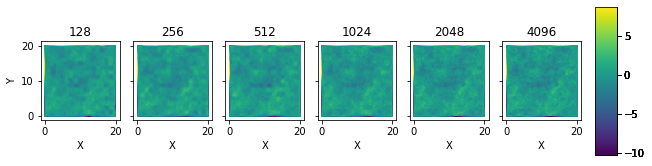

In [50]:
plot((v_estimate - v0).seed[0].curl(), row_dims='seed', size=(10, 2.5))

It may be difficult to see, but the error decreases with increasing particle count. Let's plot this quantitatively.

c:\phd\phiflow2\phi\vis\_vis_base.py:516: UserWarning: bounds argument is deprecated since 2.5 and will be ignored.
  return PointCloud(equal_spacing, values=obj, bounds=Box(lower, upper))
c:\phd\phiflow2\phi\vis\_matplotlib\_matplotlib_plots.py:286: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  subplot.set_ylim((0, float(math.finite_max(data.values, shape)) * 1.1))


<Figure size 288x216 with 1 Axes>

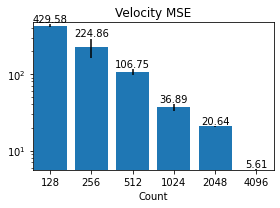

In [25]:
v_mse = math.l2_loss(v_estimate - v0).count.as_instance()
plot(math.mean(v_mse, 'seed'), err=math.std(v_mse, 'seed'), title="Velocity MSE", log_dims='_', size=(4, 3))

Having recorded the optimization trajectories earlier, we can now see how the error decreases during the optimization.

<Figure size 360x216 with 2 Axes>

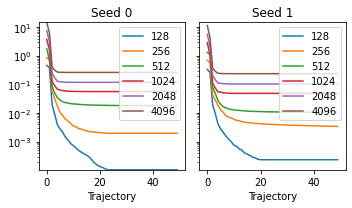

In [37]:
plot(solves[0].residual.count.as_channel().trajectory.as_spatial(), size=(5, 3), log_dims='_')

In [43]:
v_trj = solves[0].x.at(v0)
plot((v_trj - v0).count['4096'].curl(), size=(5, 3), animate='trajectory')